In [1]:

import os
import sys
import pickle
import warnings
import time
import logging
import glob

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf

from utils import *
from AnalyseDefects_dev import AnalyseDefects

plt.style.use('sg_article')


0.0195 200
0.0205 200
0.021 200
0.0215 200
0.022 200
[        inf 57.15267046 64.4329568  67.6258231  76.30186766]
[        inf 74.45002886 78.14671404 77.65703792 89.11630335]


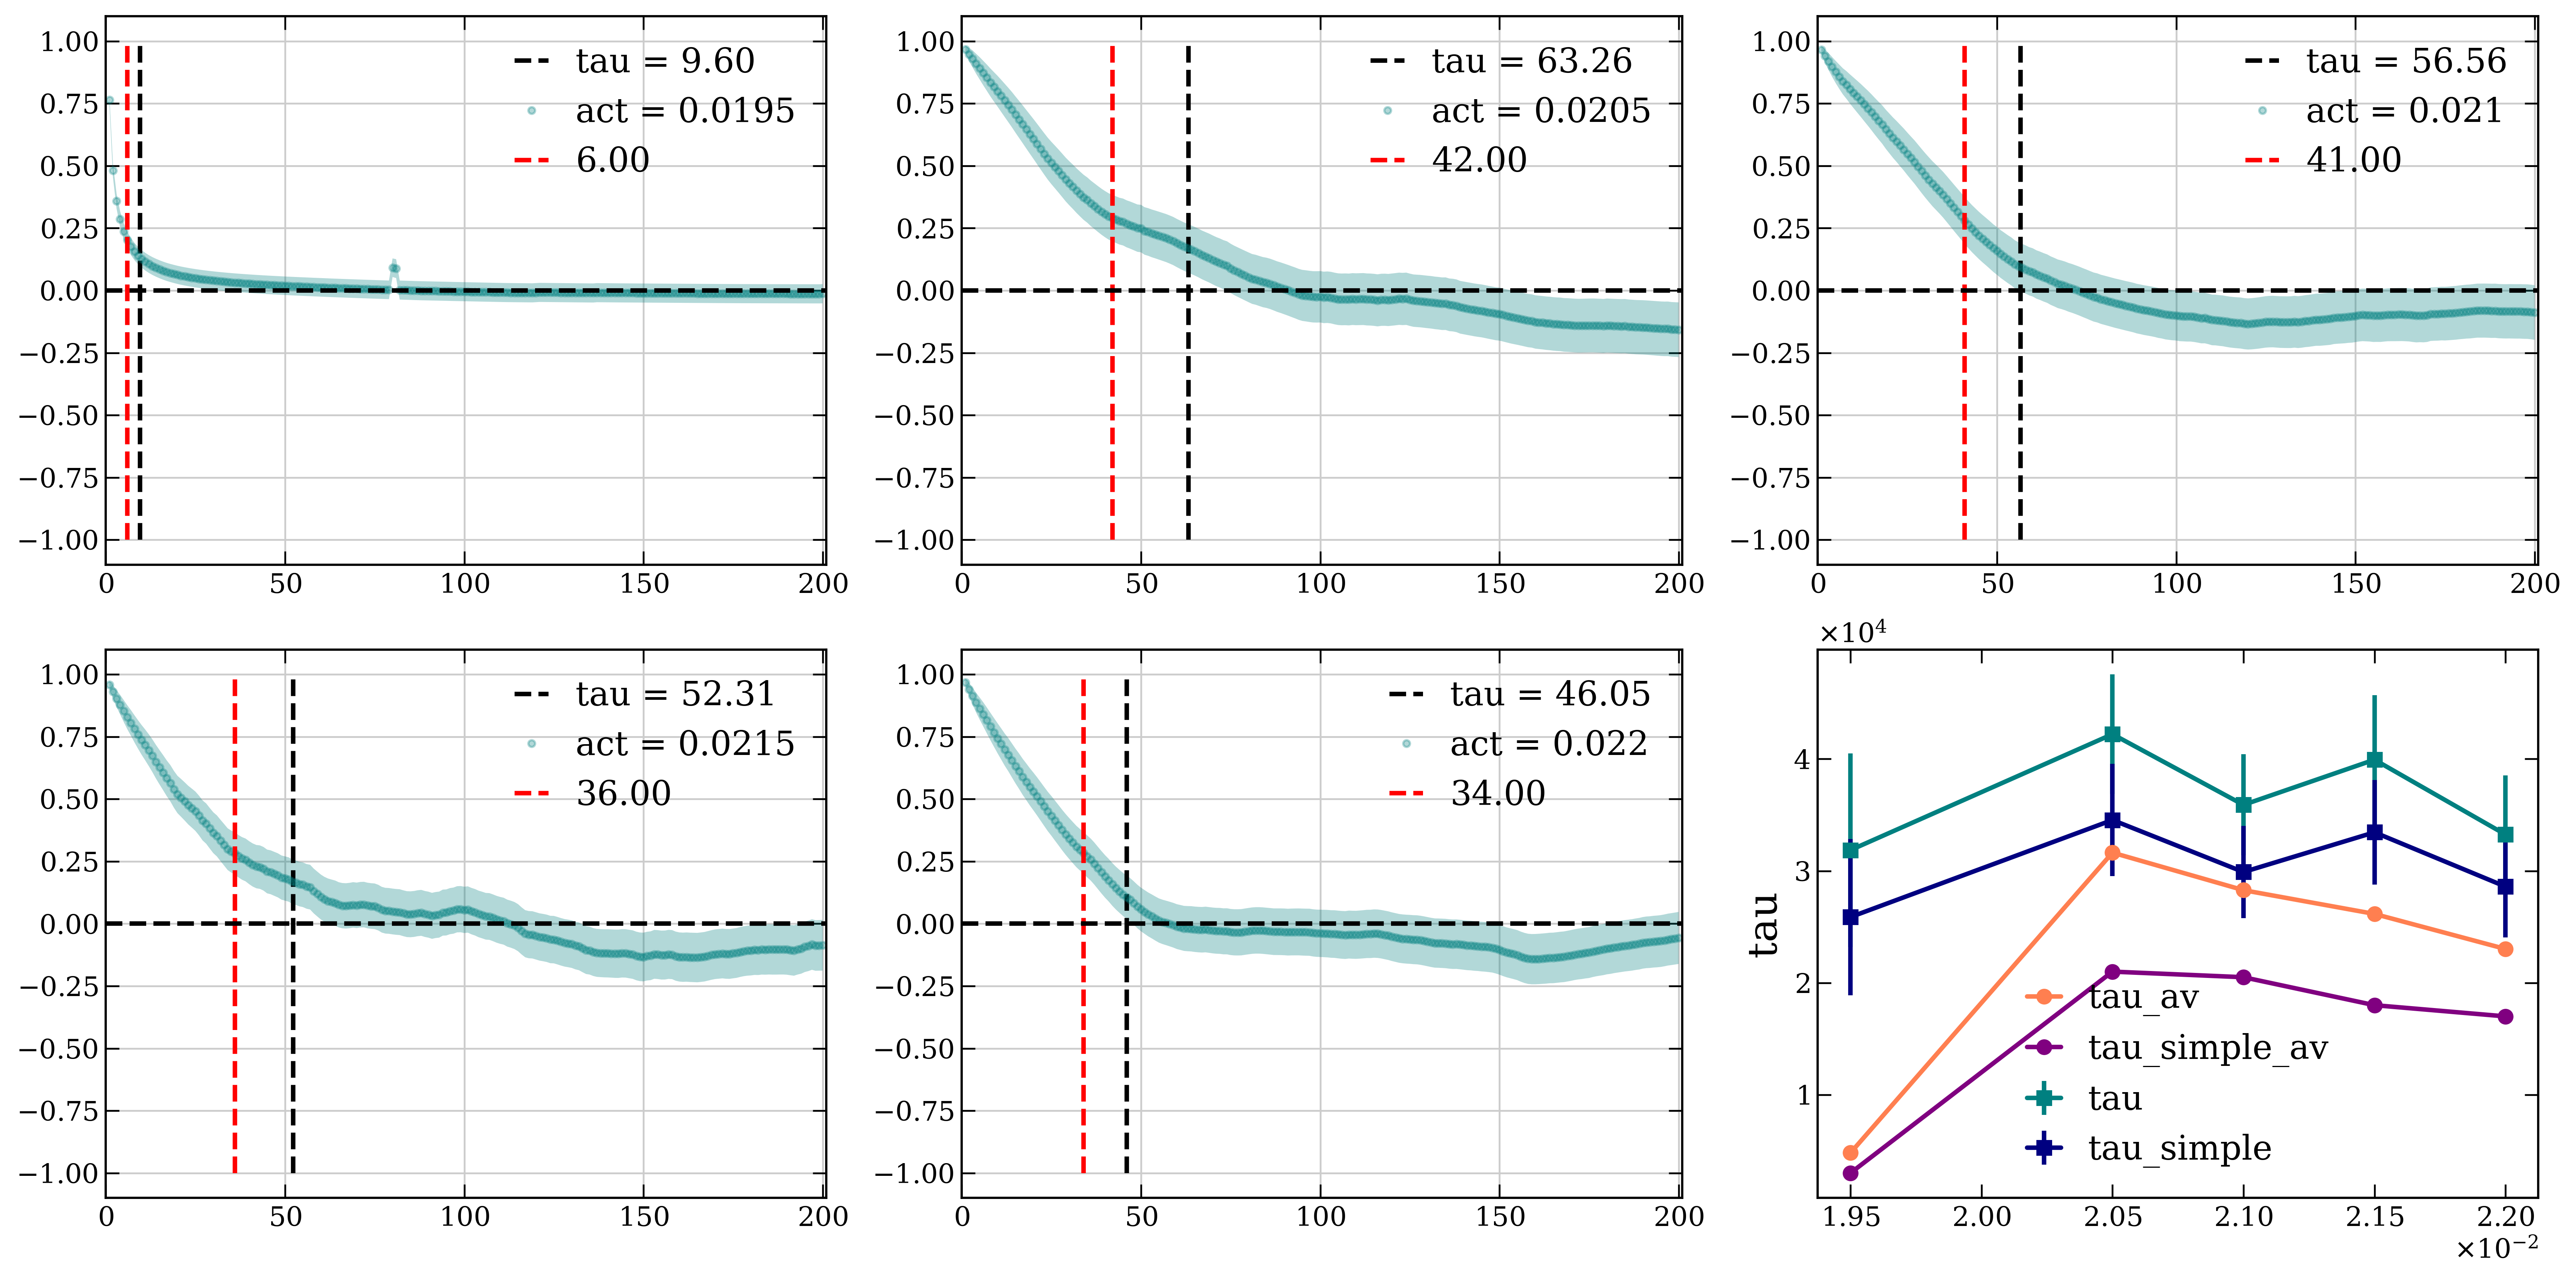

In [ ]:

LL = 512
output_path = f'data\\na{LL}'

mode = 'all' # 'all' or 'short'
find_nlag_orig = True
defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

N = -1
ninfo=500
def_arr = ad.get_arrays_full(Ndataset=N)[0]
kbins, sfac = ad.get_sfac_pcf(Ndataset=N, time_av=False)[:2]
act_list = ad.act_list[N]
conv_list = ad.conv_list[N] 

act_list = ad.act_list[N]
Nexp = ad.Nexp[N]
ndist_arr = np.zeros((len(act_list), Nexp, 2)) 
neff_arr = np.zeros((len(act_list)))
neff_arr_simple = np.zeros((len(act_list)))
tau_av_arr = np.zeros((len(act_list), 2))

use_error_bound = False
max_lag = None
alpha = 1 - 0.3413 * 2
threshold_eff_sample = 0
simple_threshold = 0.2

nrows = len(act_list) // 3 + 1 #if len(act_list) % 3 != 0 else len(act_list) // 3
fig, ax = plt.subplots(ncols = 3, nrows = nrows, figsize=(16, 4*nrows))
ax = ax.flatten()

def fit_exp(t, tau, beta):
                    return beta * np.exp(- t / tau)

param_guess = np.array([0.9, 30])
fit_string = r'$y = \beta e^{(-t/ \tau_0)}$'
Nparams = len(param_guess)

for j, act in enumerate(act_list[:]):
    act_idx = act_list.index(act)

    conv_idx = 1100 if LL < 2048 else 0
    if find_nlag_orig:
        #conv_idx = 750 #conv_list[act_idx]
        lag_frac = .7
        nf = def_arr.shape[0] - conv_idx
        nlags= int(750/2 if LL < 2048 else 400/2) 
        nlags=200
        nlags = int(min(nf * nlags, nlags))
    else:
       # conv_idx = conv_list[act_idx]
        lag_frac = .5
        nf = def_arr.shape[0] - conv_idx
        nlags = int(nf * lag_frac)

    print(act, nlags)
   # nlags=500
    #conv_idx=500#1100
    frames = np.arange(nlags +1)
    acf_arr, confint_arr = calc_acf_for_arr(def_arr[:, act_idx, :], conv_idx = conv_idx, nlags = nlags, alpha = alpha)

    confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

    acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
    tau_av, tau_simple_av = estimate_effective_sample_size(acf_avg, confint_avg,
                            max_lag_threshold=threshold_eff_sample, simple_threshold=simple_threshold, max_lag=max_lag,)
    tau_av_arr[j] = tau_av, tau_simple_av


    ax[j].vlines(tau_av, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau_av:.2f}')
    ax[j].plot(frames, acf_avg, '.', alpha=.3, label = f'act = {act}')  
    ax[j].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
    ax[j].vlines(tau_simple_av, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(tau_simple_av))

    ax[j].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
    ax[j].set_xlim(0, len(frames))
    ax[j].grid(True)
    ax[j].legend();
   # ax[j].set_yscale('log') 

    for k in range(Nexp):
        if LL==512 and act == 0.0195 and k == 7:
            continue
      #  if LL==256 and act == 0.021 and k in [0,1,6,7,8,9]:
       #     continue
        if LL==256 and act == 0.0205 and k in [8,]:
            continue
        if LL==256 and act == 0.020 and k in [1,2]:
            continue
        if LL==256 and act == 0.022 and k in [5]:
            continue
        if LL==256 and act == 0.0195 and k in [0,1, 3, 5, 6,9]:
            continue
        if LL==1024 and act == 0.019 and k in [0]:
            continue
        if LL==2048 and act == 0.019 and k in [0]:
            continue

        acf_vals = acf_arr[- (nlags + 1):,k]
        confint_vals = confint_arr[- (nlags + 1):,:,k]

        tau, tau_simple = estimate_effective_sample_size(acf_vals, acf_err_vals=None,\
                                                    confint_vals =confint_vals, max_lag=max_lag, 
                                                    max_lag_threshold=threshold_eff_sample,
                                                    simple_threshold = simple_threshold, use_error_bound=use_error_bound)

        ndist_arr[j, k] = [tau, tau_simple]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        neff_arr[j] = np.nansum(nf / ndist_arr[j,:,0])
        neff_arr_simple[j] = np.nansum(nf / ndist_arr[j,:,1])

normalize = True
multiplier = ninfo * np.ones_like(act_list) #np.array(act_list) #np.ones_like(act_list)
multiplier[-3] *= 1 #8 if LL == 1024 else 1
ndist_arr *= multiplier[:,None,None] 
tau_av_arr *= multiplier[:,None]

ax[-1].errorbar(act_list, np.nanmean(ndist_arr[:,:,0], axis=1), np.nanstd(ndist_arr[:,:,0], axis=1, ddof = 1) / np.sqrt(Nexp), marker='s', label='tau')
ax[-1].errorbar(act_list, np.nanmean(ndist_arr[:,:,1], axis=1), np.nanstd(ndist_arr[:,:,1], axis=1, ddof = 1) / np.sqrt(Nexp), marker='s', label='tau_simple')
ax[-1].plot(act_list, tau_av_arr[:,0], 'o-', label='tau_av')
ax[-1].plot(act_list, tau_av_arr[:,1], 'o-', label='tau_simple_av')
#ax[-1].plot(act_list, ndist_arr[:,0,1], 'o-', label='tau_simple')
#ax[-1].set_xlabel('activity')
ax[-1].set_ylabel('tau')
ax[-1].legend()

print(neff_arr)
print(neff_arr_simple)

In [12]:
acf_arr.shape

(1501, 10)

In [5]:
ndist_arr[:,:,:].shape

(5, 10, 2)

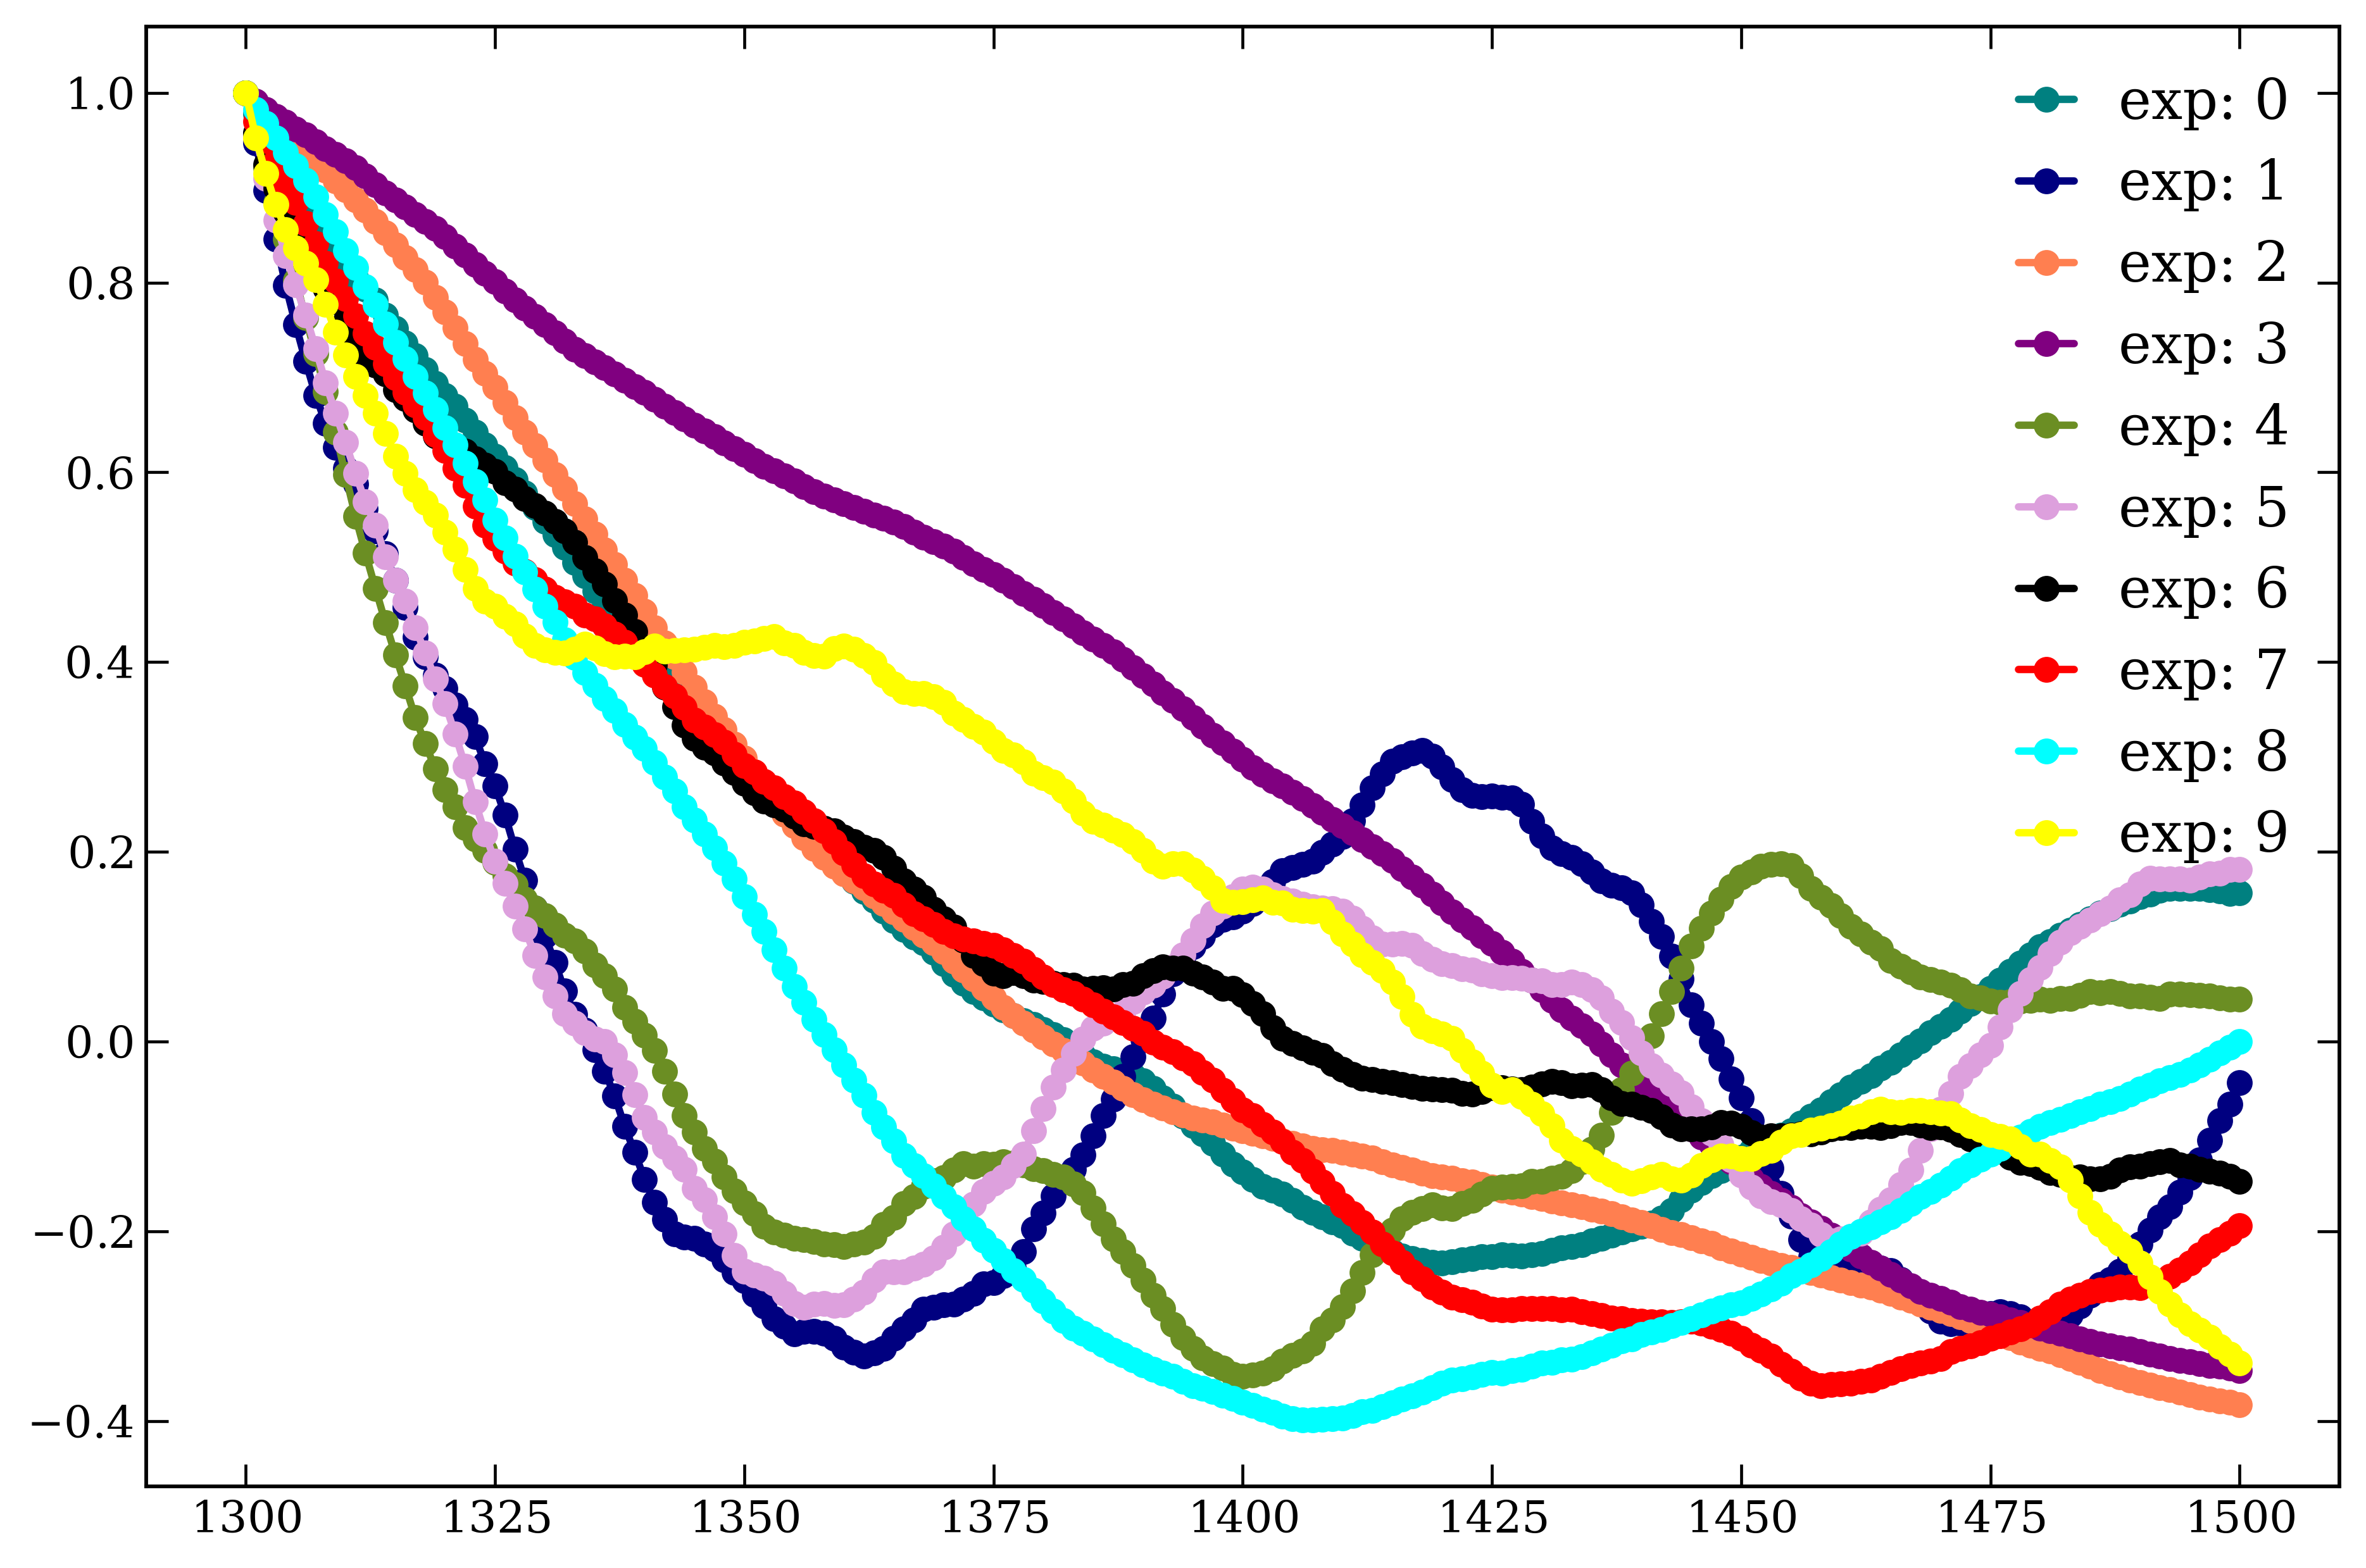

In [13]:
for i in range(ad.Nexp[-1]):
    plt.plot(np.arange(acf_arr.shape[0]), acf_arr[:,i], 'o-', label=f'exp: {i}')

plt.legend()